In [1]:
import pandas as pd
import numpy as np

from lightgbm import LGBMRegressor
import lightgbm as lgb

import pickle
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import random
import gc

In [2]:
%who DataFrame

No variables match your requested type.


In [2]:
#loading data from 2015
# df= pd.read_pickle("final_data_till_1969_without_encoding.pkl")
df= pd.read_pickle("final_data_from_2015_till_1969_with_encoding.pkl")

#we create a dicitonary for id and its encodings
id_dict= pd.read_csv("ids_dict.csv")
id_dict= dict(zip(id_dict['id'], id_dict['uid']))

sales= pd.read_csv('sales_train_evaluation.csv')

In [3]:
'''here we are importing sales dataset and we are creating few column orders '''

d_cols= [col for col in sales.columns if 'd_' in col] 
non_d_cols= [col for col in sales.columns if 'd_' not in col] 

last_28_d_cols= []
for i in range(1942, 1970):
    last_28_d_cols.append("d_"+ str(i))
    
d_cols_1969= d_cols + last_28_d_cols

f_cols= [ ("F"+str(i+1)) for i in range(28)]
d_with_f_cols= d_cols+ f_cols

col_order= d_cols + ['level', 'weights']
col_order_with_f_cols= d_with_f_cols+['level', 'weights']
col_order_with_f_cols_without_level= d_with_f_cols+['weights']

uid= sales.id.unique() #getting all unique id's from test data

# in kaggle submission file we have to predict last 56 days data from day 1885 for each item
# getting validation ids for each item sales from day 1885 - day 1913
validation_uid= ["_".join(ids.split("_")[:-1] + ["validation"]) for ids in uid] 

In [1]:
'''splitting to train and test dataset'''

valid = df[df['d']<=1913][['id','d','sales', 'revenue']]
test = df[(df['d']>1913) & (df['d']<=1941)][['id','d','sales', 'revenue']]
evaluation= df[df['d']>1941]

valid['id']= valid['id'].apply(lambda x: id_dict[x])
test['id']= test['id'].apply(lambda x: id_dict[x])

valid_df= valid.groupby('id')
test_df= test.groupby('id')

NameError: name 'df' is not defined

In [5]:
df.head()

,id,state_id,store_id,cat_id,dept_id,item_id,d,sales,wm_yr_wk,wday,...,lag_28,rolling_mean1,rolling_mean2,rolling_mean3,rolling_mean7,rolling_mean14,rolling_mean21,rolling_mean28,rolling_mean60,rolling_mean90
1433,14370,0,0,1,3,1437,1434,0,11448,6,...,1.0,0.0,0.0,0.333252,1.286133,0.856934,0.856934,0.785645,0.716797,0.666504
1434,14370,0,0,1,3,1437,1435,0,11448,7,...,1.0,0.0,0.0,0.000000,1.142578,0.856934,0.856934,0.750000,0.700195,0.644531
1435,14370,0,0,1,3,1437,1436,0,11449,1,...,1.0,0.0,0.0,0.000000,1.000000,0.714355,0.761719,0.714355,0.700195,0.644531
1436,14370,0,0,1,3,1437,1437,0,11449,2,...,0.0,0.0,0.0,0.000000,0.285645,0.714355,0.571289,0.714355,0.700195,0.633301
1437,14370,0,0,1,3,1437,1438,0,11449,3,...,1.0,0.0,0.0,0.000000,0.142822,0.714355,0.571289,0.678711,0.700195,0.600098


### Metric

In [6]:
## correct one and currently using this finally -------------------------------------------modifications 4 finally correct

def get_level_12_weights(isvalidation):
    '''calculating last 28 day revenue and weights'''
    #if isvalidation = True, validation data will be from day 1857 -1885
    #if isvalidation= False, validation data will be from day 1885 -1913
    # print("calculating level 12 weights...")
    last_28_day_revenue= []
    weights= [] 
    
    if isvalidation:
        for i in uid: #uid= unique ids
            last_28_day_revenue.append(valid_df.get_group(i)['revenue'].dropna()[-56:-28].values.sum())

        for i in last_28_day_revenue:
            weights.append(i/ sum(last_28_day_revenue))
        
        return weights
    
    else:
        for i in uid: #uid= unique ids
            last_28_day_revenue.append(valid_df.get_group(i)['revenue'].dropna()[-28:].values.sum())

        for i in last_28_day_revenue:
            weights.append(i/ sum(last_28_day_revenue))
                        
        return weights
    
    
def calculate_weights(sales, prediction, aggregation_level, isvalidation):
    '''this function will calculate weights acc to level 12'''
    
#     temp part
    if isvalidation:
        weights= valid_weights
    else:
        weights= test_weights
   
#     https://www.youtube.com/watch?v=7FwITPrBvLI&list=PLu4R9FIFLvWmRgHTH2Br-Di6koS_D7oL7&index=3
#     weights= get_level_12_weights(isvalidation) #calling function, calculating weights
    sales['weights']= weights #adding weights
    sales= sales.merge(prediction, on= 'id', how='left') #sales with fcols(i.e prediction data)
    sales2= sales[col_order_with_f_cols_without_level] #creating another dataframe bcoz this dataframe values will be used ahead

    # print('calculating weights aggregate level...')

    #creating new dataframe to store aggregate data weights and revenue
    aggregation_data= pd.DataFrame(sales2.sum()).T
    aggregation_data['level']=1
    aggregation_data['weights']= 1/12
    ag_df= aggregation_data[col_order_with_f_cols]

    #iterating over all the agg levels
    for i in aggregation_level.keys(): #getting weights for all other levels
        temp= sales.groupby(aggregation_level[i]).sum().reset_index(drop=True)
        temp['level']= i
        temp['weights'] /= 12
        temp= temp[col_order_with_f_cols]
        aggregation_data= pd.concat([aggregation_data,temp])

    sale= sales2.copy()
    sale['weights'] /= 12
        
    return sale, aggregation_data



def rmsse(actual, predicted, historical):
    '''this function will calculate the rmsse values'''
    
    actual= np.array(actual)
    predicted= np.array(predicted)
    historical= np.array(historical)
    h= len(actual[0])
    n= len(historical[0])

    numerator= ((actual- predicted)**2).sum(axis=1)
    denominator= (1/n)*((historical[:, 1:] - historical[:, :-1]) ** 2).sum(axis=1)
    rmsses= np.sqrt((numerator/denominator) * (1/ h))
    return rmsses


    
def calculate_wrmsse(sale, aggregation_data, isvalidation):
    '''this function will calculate wrmsse'''
    
    if isvalidation:
        historical_cols= d_cols[:-56]
        actual_cols= d_cols[-56:-28]

        predicted_cols= f_cols
        
    else:
        historical_cols= d_cols[:-28]
        actual_cols= d_cols[-28:]
        predicted_cols= f_cols        

    # print('calculating rmsse...')

    
    rmsse_sale= rmsse(sale[actual_cols], sale[predicted_cols], sale[historical_cols])
    rmsse_agg= rmsse(aggregation_data[actual_cols], aggregation_data[predicted_cols], aggregation_data[historical_cols])
    
    # print('calculating wrmsse...')

    wrmsse_sale= rmsse_sale * sale['weights']
    wrmsse_agg= rmsse_agg * aggregation_data['weights']

    wrmsse= wrmsse_agg.sum() + wrmsse_sale.sum()
    return wrmsse



def wrmsse(sales, prediction, isvalidation):
    '''this function will call all other functions as requires so as to make work easier'''
    
    #all the aggregation levels present in the data
    aggregation_level = {2: ["state_id"], 3: ["store_id"], 4: ["cat_id"], 5: ["dept_id"], 6: ["state_id", "cat_id"], 
                         7: ["state_id", "dept_id"], 8: ["store_id", "cat_id"], 
                         9: ["store_id", "dept_id"], 10: ["item_id"], 11: ["item_id", "state_id"]}
    
    
    weights= 0

    sale, aggregation_data= calculate_weights(sales, prediction, aggregation_level, isvalidation)
    wrmsses=calculate_wrmsse(sale, aggregation_data, isvalidation)
    
    return wrmsses


In [7]:
valid_weights= get_level_12_weights(True)
test_weights= get_level_12_weights(False)

### Model Building

## LightGBM

In [223]:
learning_rate= [0.01, 0.1, 1]
n_estimators= [900,1500,100]

In [300]:
unique_store= list(df_df.store_id.unique())
valid_prediction= []
test_prediction= []

for estimator in tqdm(n_estimators):
    for eta in learning_rate:
        params = {
            'objective': 'regression',
            'num_iterations' : estimator,
            'boosting_type': 'gbdt',
            'metric': 'rmse',
            'n_jobs': -1,
            'learning_rate': eta
                      }

        valid_pred= pd.DataFrame(columns= ['id']+ f_cols)
        test_pred= pd.DataFrame(columns= ['id']+ f_cols)

        for store in unique_store:
            valid_temp= pd.DataFrame(columns= ['id']+ f_cols)

            test_temp= pd.DataFrame(columns= ['id']+ f_cols)

            ############################################
            data= df_df[df_df['store_id']== store]

            train_data= data[data['d'] <= 1885]
            valid_data= data[(data['d'] >1885) & (data['d']<1914)]
            test_data= data[data['d']>= 1914]

            X_train, y_train= train_data.drop('sales', axis= 1), train_data['sales']
            X_valid, y_valid= valid_data.drop('sales', axis= 1), valid_data['sales']
            X_test, y_test= test_data.drop('sales', axis= 1), test_data['sales']

            train_set = lgb.Dataset(X_train, label= y_train)
            val_set = lgb.Dataset(X_valid, label= y_valid)
            ############################################

            model = lgb.train(params, train_set)#, valid_sets=[val_set])#, verbose_eval=20)
            ###########################################################
            valid_temp = model.predict(X_valid)
            valid_temp= valid_temp.reshape(-1,28)


            prediction= pd.DataFrame(valid_temp, columns= f_cols)
            prediction['id']= valid_data.id.unique()
            cols= ['id'] + f_cols
            prediction= prediction[cols]

            valid_pred= pd.concat([valid_pred, prediction])
            ###############################################
            test_temp = model.predict(X_test)
            test_temp = test_temp.reshape(-1,28)

            prediction= pd.DataFrame(test_temp, columns= f_cols)
            prediction['id']= test_data.id.unique()
            cols= ['id'] + f_cols
            prediction= prediction[cols]

            test_pred= pd.concat([test_pred, prediction])
            ###########################################################

        valid_pred.reset_index(drop= True, inplace= True)
        test_pred.reset_index(drop= True, inplace= True)

        for i in valid_pred.columns[1:]:
            valid_pred[i]= valid_pred[i].apply(lambda x: int(np.round(x,0)))

        for i in test_pred.columns[1:]:
            test_pred[i]= test_pred[i].apply(lambda x: int(np.round(x,0)))

        print("for validation:")
        wrmss= wrmsse(sales, valid_pred, aggregation_level)
        print("n_estimators= ", estimator, 'learning_rate= ', eta, 'WRMSSE= ',wrmss, '\n')    

        print("for validation:")
        wrmss= wrmsse(sales, test_pred, aggregation_level)
        print("n_estimators= ", estimator, 'learning_rate= ', eta, 'WRMSSE= ',wrmss, '\n')                        

        valid_prediction.append(valid_pred)
        test_prediction.append(test_pred)








  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3862
[LightGBM] [Info] Number of data points in the train set: 1378148, number of used features: 32
[LightGBM] [Info] Start training from score 1.441474
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.218750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3700
[LightGBM] [Info] Number of data points in the train set: 1378148, number of used features: 32
[LightGBM] [Info] Start training from score 1.139306
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.338562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 1378148, number of used features: 32
[LightGBM] [Info] Start training from score 1.108849
for validation:
calculating level 12 weights...
calculating weights aggregate level...
calculating rmsse...
calculating wrmsse...
n_estimators=  900 learning_rate=  0.1 WRMSSE=  0.0026710105815421197 

for validation:
calculating level 12 weights...
calculating weights aggregate level...
calculating rmsse...
calculating wrmsse...
n_estimators=  900 learning_rate=  0.1 WRMSSE=  0.8829116464477424 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.243587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not en

calculating wrmsse...
n_estimators=  900 learning_rate=  1 WRMSSE=  0.8829742740632018 



 33%|██████████████████████████                                                    | 1/3 [1:48:17<3:36:34, 6497.14s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.164269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3862
[LightGBM] [Info] Number of data points in the train set: 1378148, number of used features: 32
[LightGBM] [Info] Start training from score 1.441474
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.398082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3700
[LightGBM] [Info] Number of data points in the train set: 1378148, number of used features: 32
[LightGBM] [Info] Start training from score 1.139306
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

for validation:
calculating level 12 weights...
calculating weights aggregate level...
calculating rmsse...
calculating wrmsse...
n_estimators=  1500 learning_rate=  0.1 WRMSSE=  0.00272168651474456 

for validation:
calculating level 12 weights...
calculating weights aggregate level...
calculating rmsse...
calculating wrmsse...
n_estimators=  1500 learning_rate=  0.1 WRMSSE=  0.8828716753671811 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3862
[LightGBM] [Info] Number of data points in the train set: 1378148, number of used features: 32
[LightGBM] [Info] Start training from score 1.441474
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.210438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not en








 67%|████████████████████████████████████████████████████                          | 2/3 [4:33:59<2:05:30, 7530.71s/it]

calculating wrmsse...
n_estimators=  1500 learning_rate=  1 WRMSSE=  0.8829684490100296 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.167907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3862
[LightGBM] [Info] Number of data points in the train set: 1378148, number of used features: 32
[LightGBM] [Info] Start training from score 1.441474
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.324508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3700
[LightGBM] [Info] Number of data points in the train set: 1378148, number of used features: 32
[LightGBM] [Info] Start training from score 1.139306
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.323589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3881
[LightGBM] [Info] Number of data points in the train set: 1378148, number of used features: 32
[LightGBM] [Info] Start training from score 1.108849
for validation:
calculating level 12 weights...
calculating weights aggregate level...
calculating rmsse...
calculating wrmsse...
n_estimators=  100 learning_rate=  0.1 WRMSSE=  0.0024409277044324215 

for validation:
calculating level 12 weights...
calculating weights aggregate level...
calculating rmsse...
calculating wrmsse...
n_estimators=  100 learning_rate=  0.1 WRMSSE=  0.8829129573659653 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.674060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total








100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [5:08:38<00:00, 6172.97s/it]

calculating wrmsse...
n_estimators=  100 learning_rate=  1 WRMSSE=  0.8830959081473213 



In [304]:
wrmss= wrmsse(sales, valid_pred, True)
wrmss

calculating level 12 weights...
calculating weights aggregate level...
calculating rmsse...
calculating wrmsse...


0.0040200780602895935

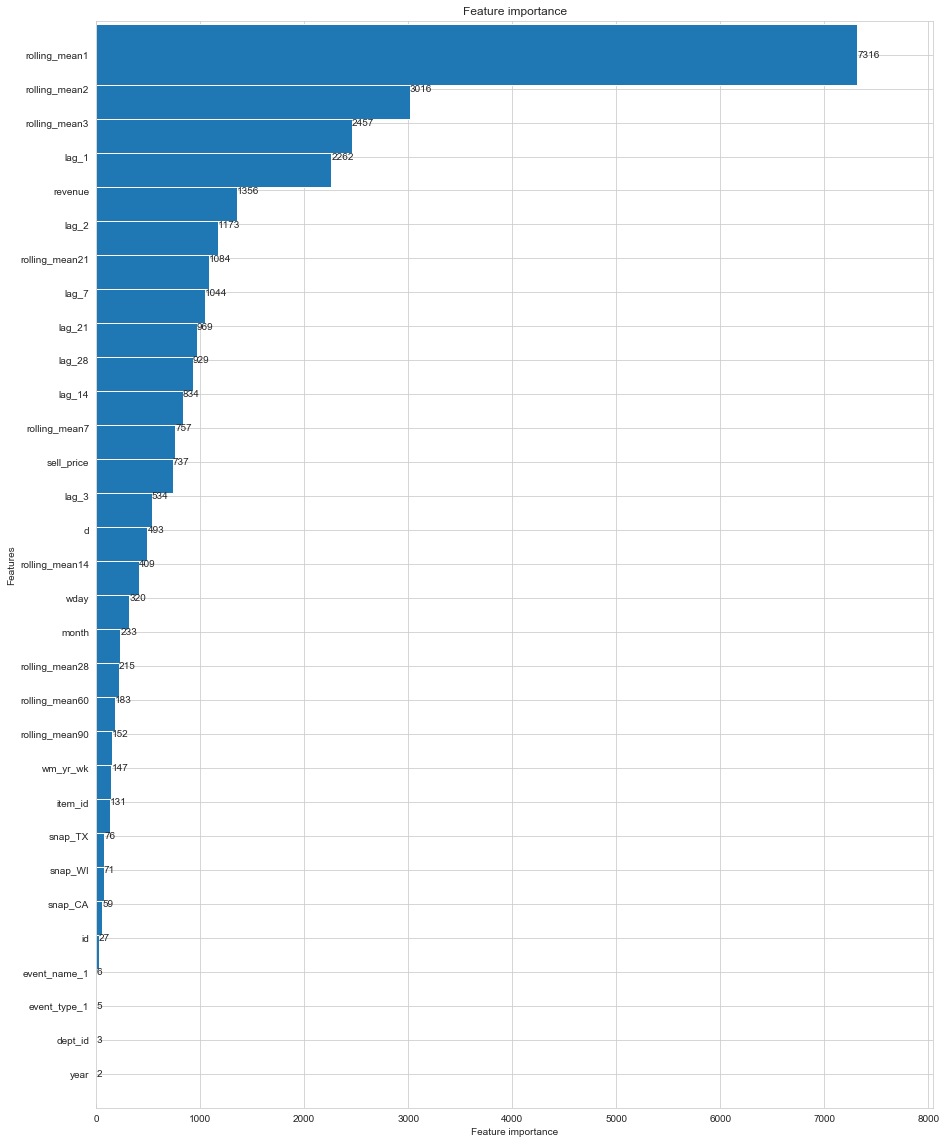

In [253]:
#plotting feature importances
lgb.plot_importance(model, height=1.8, figsize=(15,20))

In [302]:
wrmss= wrmsse(sales, test_pred, aggregation_level)

calculating level 12 weights...
calculating weights aggregate level...
calculating rmsse...
calculating wrmsse...


### After Removing few features

In [8]:
df_df= df.drop(['wm_yr_wk', 'lag_1', 'lag_2', 'lag_3', 'lag_14', 'lag_21', 'rolling_mean1', 'rolling_mean2',
       'rolling_mean3', 'rolling_mean14', 'rolling_mean21'], axis= 1)

In [12]:
objective= ['poisson', 'regression']
learning_rate= [0.005, 0.075, 0.01, 0.1]
num_iterations= [2000, 1400, 1200, 1000, 800, 600, 400]
max_depth= [-1, 11, 9, 7, 5, 3]
num_leaves= [100, 150, 200, 250, 300, 400, 500, 600, 700]
min_data_in_leaf= [100, 200, 300, 500, 1000, 2000]
max_bins= [100, 150, 200, 250, 300, 400, 500]

In [11]:
store_dict= dict(zip(df_df.store_id.unique(), sales.store_id.unique()))
uid_df= pd.DataFrame(uid, columns=['id'])

#### Randomized CV

In [13]:
models=[] #will store models for all iterations
predicted_values_validation=[]
for i in range(20):
    mod=[] #will store models for this iteration
    print(f"No of times remaining: {20 - (i+1)}")
    validation_prediction= pd.DataFrame(columns= ['id']+ f_cols)
    test_prediction= pd.DataFrame(columns= ['id']+ f_cols)

    for store in list(df_df.store_id.unique()):
        eta= random.choice(learning_rate)
        iterations= random.choice(num_iterations)
        depth= random.choice(max_depth)
        leaves= random.choice(num_leaves)
        min_data= random.choice(min_data_in_leaf)
        bins= random.choice(max_bins)


        print("-"*110)
        print(f"store {store + 1}: {store_dict[store]}, eta: {eta}, num_iterations: {iterations}, max_depth: {depth}, num_leaves: {leaves}, min_data_in_leaf: {min_data}, max_bins: {bins}")
        print("-"*110)


        params={
          'objective':'poisson',
          'metric':'rmse',
          'force_row_wise':True,
          'learning_rate': eta,
          'max_bin': bins,
          'verbosity': -1,  #with this it stops giving warnings
          'num_iterations':iterations, 
          'num_leaves': leaves, 
          'min_data_in_leaf': min_data,
          'max_depth': depth,
          'n_jobs': -1
        }

        data= df_df[df_df['store_id']== store] #getting data by store

        #creating train and test datasets
        train= data[data['d'] <= 1885].drop(['id','d'], axis= 1)
        valid= data[(data['d'] >1885) & (data['d']<1914)].drop('d', axis= 1)
        test= data[(data['d']>= 1914) & (data['d'] <= 1941)].drop('d', axis= 1)

        #getting the ids of valid and test datasets so as to sort them afterwords
        valid_id= list(valid['id'].values)
        test_id= list(test['id'].values)

        #dropping id now 
        valid.drop('id', axis= 1, inplace= True)
        test.drop('id', axis= 1, inplace= True)

        X_train, y_train= train.drop('sales', axis= 1), train['sales']
        X_valid, y_valid= valid.drop('sales', axis= 1), valid['sales']
        X_test, y_test= test.drop('sales', axis= 1), test['sales']
#         X_eval, y_eval= evaluation.drop('sales', axis= 1), evaluation['sales']
        

        # Defining categorical features
        categories = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + \
                   ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]

        trainData = lgb.Dataset(X_train, label = y_train, categorical_feature = categories, free_raw_data = False)
        validData = lgb.Dataset(X_valid, label = y_valid, categorical_feature = categories, free_raw_data = False)

        #training model
        model = lgb.train(params, trainData, valid_sets = [trainData, validData], verbose_eval = 200, early_stopping_rounds=20)
        mod.append(model) #appending model

        #predicting validation and test data
        valid_predict= model.predict(X_valid).reshape(-1,28)
        valid_predict= pd.DataFrame(valid_predict, columns= f_cols)
        valid_predict['id']= valid_id[::28] #adding ids
        cols= ['id'] + f_cols
        valid_predict= valid_predict[cols]

        #concatinating it with larger dataset for computing WRMSSE
        validation_prediction= pd.concat([validation_prediction, valid_predict]) 


        test_predict= model.predict(X_test).reshape(-1,28)
        test_predict= pd.DataFrame(test_predict, columns= f_cols)
        test_predict['id']= test_id[::28] #adding ids
        cols= ['id'] + f_cols
        test_predict= test_predict[cols]

        #concatinating it with larger dataset for computing WRMSSE
        test_prediction= pd.concat([test_prediction, test_predict]) 
        
    models.append(mod)#appending all models in this iteration

    #sorting them by ids 
#     validation_prediction= validation_prediction.sort_values(by= 'id')
    validation_prediction['id']= validation_prediction['id'].apply(lambda x: id_dict[x])
    validation_prediction= uid_df.merge(validation_prediction, on= 'id', how= 'left')

#     test_prediction= test_prediction.sort_values(by= 'id')
    test_prediction['id']= test_prediction['id'].apply(lambda x: id_dict[x])
    test_prediction= uid_df.merge(test_prediction, on= 'id', how= 'left')
    
    predicted_values_validation.append(test_prediction)

    print('calculating WRMSSE')
    #calculating validation and evaluation wrmsse
    valid_wrmsse= wrmsse(sales, validation_prediction, True)

    eval_wrmsse= wrmsse(sales, test_prediction, False)

    print('\n')
    print("#"*100)
    print(f"for validation= \n eta: {eta}, num_iterations: {iter}, num_leaves: {leaves}, min_data_in_leaf: {min_data}, WRMSSE:{valid_wrmsse}")
    print(f"for evaluation= \n eta: {eta}, num_iterations: {iter}, num_leaves: {leaves}, min_data_in_leaf: {min_data}, WRMSSE:{eval_wrmsse}")
    print("#"*100)
    print('\n')
    print("-+-"*35)
    print("-+-"*35)
    print('\n')

No of times remaining: 19
--------------------------------------------------------------------------------------------------------------
store 1: CA_1, eta: 0.075, num_iterations: 1400, max_depth: 3, num_leaves: 300, min_data_in_leaf: 1000, max_bins: 200
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.953529	valid_1's rmse: 0.92725
[400]	training's rmse: 0.661466	valid_1's rmse: 0.640295
[600]	training's rmse: 0.528496	valid_1's rmse: 0.524064
[800]	training's rmse: 0.457798	valid_1's rmse: 0.458067
[1000]	training's rmse: 0.417838	valid_1's rmse: 0.419374
[1200]	training's rmse: 0.395994	valid_1's rmse: 0.401168
Early stopping, best iteration is:
[1230]	training's rmse: 0.393541	valid_1's rmse: 0.397429
--------------------------------------------------------------------------------------------------------------
store 2: CA_2, eta: 0.075,

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.664329	valid_1's rmse: 0.609663
[400]	training's rmse: 0.559051	valid_1's rmse: 0.514883
[600]	training's rmse: 0.517887	valid_1's rmse: 0.482052
[800]	training's rmse: 0.486294	valid_1's rmse: 0.463841
[1000]	training's rmse: 0.464988	valid_1's rmse: 0.451704
[1200]	training's rmse: 0.449422	valid_1's rmse: 0.443667
Did not meet early stopping. Best iteration is:
[1200]	training's rmse: 0.449422	valid_1's rmse: 0.443667
--------------------------------------------------------------------------------------------------------------
store 2: CA_2, eta: 0.005, num_iterations: 2000, max_depth: 3, num_leaves: 700, min_data_in_leaf: 200, max_bins: 150
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.08873	valid_1's rmse: 2.20838
[400]	training's rmse: 1.60413	val

--------------------------------------------------------------------------------------------------------------
store 1: CA_1, eta: 0.005, num_iterations: 800, max_depth: 7, num_leaves: 300, min_data_in_leaf: 100, max_bins: 400
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.26625	valid_1's rmse: 2.17957
[400]	training's rmse: 1.44004	valid_1's rmse: 1.39197
[600]	training's rmse: 0.945731	valid_1's rmse: 0.924276
[800]	training's rmse: 0.660496	valid_1's rmse: 0.658509
Did not meet early stopping. Best iteration is:
[800]	training's rmse: 0.660496	valid_1's rmse: 0.658509
--------------------------------------------------------------------------------------------------------------
store 2: CA_2, eta: 0.075, num_iterations: 800, max_depth: 3, num_leaves: 100, min_data_in_leaf: 1000, max_bins: 200
--------------------------------------------

[1000]	training's rmse: 0.768165	valid_1's rmse: 0.735077
[1200]	training's rmse: 0.682237	valid_1's rmse: 0.655624
[1400]	training's rmse: 0.619479	valid_1's rmse: 0.59885
[1600]	training's rmse: 0.574918	valid_1's rmse: 0.55776
[1800]	training's rmse: 0.539919	valid_1's rmse: 0.526035
[2000]	training's rmse: 0.512141	valid_1's rmse: 0.501133
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.512141	valid_1's rmse: 0.501133
--------------------------------------------------------------------------------------------------------------
store 2: CA_2, eta: 0.075, num_iterations: 1400, max_depth: 9, num_leaves: 300, min_data_in_leaf: 500, max_bins: 200
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.316761	valid_1's rmse: 0.332256
[400]	training's rmse: 0.2679	valid_1's rmse: 0.308649
Early stopping, best iteration is:
[

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.27107	valid_1's rmse: 0.33358
[400]	training's rmse: 0.211876	valid_1's rmse: 0.293623
[600]	training's rmse: 0.185402	valid_1's rmse: 0.279519
Early stopping, best iteration is:
[609]	training's rmse: 0.184459	valid_1's rmse: 0.278772
--------------------------------------------------------------------------------------------------------------
store 3: CA_3, eta: 0.075, num_iterations: 400, max_depth: 9, num_leaves: 300, min_data_in_leaf: 500, max_bins: 250
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.690349	valid_1's rmse: 0.661555
[400]	training's rmse: 0.595524	valid_1's rmse: 0.637079
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.595524	valid_1's rmse: 0.637079
------------------------------------------------------------

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 1.14122	valid_1's rmse: 1.17375
[400]	training's rmse: 0.550118	valid_1's rmse: 0.505655
[600]	training's rmse: 0.382454	valid_1's rmse: 0.32373
[800]	training's rmse: 0.331186	valid_1's rmse: 0.285764
Did not meet early stopping. Best iteration is:
[800]	training's rmse: 0.331186	valid_1's rmse: 0.285764
--------------------------------------------------------------------------------------------------------------
store 3: CA_3, eta: 0.01, num_iterations: 2000, max_depth: 5, num_leaves: 200, min_data_in_leaf: 500, max_bins: 300
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.50112	valid_1's rmse: 2.17091
[400]	training's rmse: 1.47926	valid_1's rmse: 1.2303
[600]	training's rmse: 1.16494	valid_1's rmse: 0.980746
[800]	training's rmse: 1.02462	valid_1's rmse

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 1.27532	valid_1's rmse: 1.30239
[400]	training's rmse: 0.674775	valid_1's rmse: 0.629797
[600]	training's rmse: 0.474866	valid_1's rmse: 0.432185
[800]	training's rmse: 0.392621	valid_1's rmse: 0.362825
[1000]	training's rmse: 0.345925	valid_1's rmse: 0.325105
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.345925	valid_1's rmse: 0.325105
--------------------------------------------------------------------------------------------------------------
store 3: CA_3, eta: 0.1, num_iterations: 2000, max_depth: 3, num_leaves: 250, min_data_in_leaf: 2000, max_bins: 400
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 1.29514	valid_1's rmse: 1.19059
[400]	training's rmse: 0.789131	valid_1's rmse: 0.76614
[600]	training's rmse: 0.619985	valid_1

[400]	training's rmse: 0.780335	valid_1's rmse: 0.772645
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.780335	valid_1's rmse: 0.772645
--------------------------------------------------------------------------------------------------------------
store 4: CA_4, eta: 0.1, num_iterations: 600, max_depth: 9, num_leaves: 700, min_data_in_leaf: 500, max_bins: 100
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.242986	valid_1's rmse: 0.246793
[400]	training's rmse: 0.196724	valid_1's rmse: 0.227474
Early stopping, best iteration is:
[452]	training's rmse: 0.190813	valid_1's rmse: 0.225058
--------------------------------------------------------------------------------------------------------------
store 5: TX_1, eta: 0.1, num_iterations: 600, max_depth: 11, num_leaves: 600, min_data_in_leaf: 300, max_bins: 100
---------

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.874544	valid_1's rmse: 0.82411
[400]	training's rmse: 0.469036	valid_1's rmse: 0.428108
[600]	training's rmse: 0.334692	valid_1's rmse: 0.303524
[800]	training's rmse: 0.274557	valid_1's rmse: 0.253904
[1000]	training's rmse: 0.239399	valid_1's rmse: 0.227066
[1200]	training's rmse: 0.214058	valid_1's rmse: 0.2067
[1400]	training's rmse: 0.194111	valid_1's rmse: 0.190199
Did not meet early stopping. Best iteration is:
[1400]	training's rmse: 0.194111	valid_1's rmse: 0.190199
--------------------------------------------------------------------------------------------------------------
store 5: TX_1, eta: 0.01, num_iterations: 400, max_depth: 3, num_leaves: 300, min_data_in_leaf: 500, max_bins: 300
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 1.59591	valid

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.2914	valid_1's rmse: 0.350301
[400]	training's rmse: 0.223804	valid_1's rmse: 0.29786
[600]	training's rmse: 0.190703	valid_1's rmse: 0.277371
Did not meet early stopping. Best iteration is:
[600]	training's rmse: 0.190703	valid_1's rmse: 0.277371
--------------------------------------------------------------------------------------------------------------
store 6: TX_2, eta: 0.075, num_iterations: 1200, max_depth: 11, num_leaves: 400, min_data_in_leaf: 2000, max_bins: 400
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.457635	valid_1's rmse: 0.370957
[400]	training's rmse: 0.336457	valid_1's rmse: 0.276737
[600]	training's rmse: 0.279652	valid_1's rmse: 0.255014
Early stopping, best iteration is:
[620]	training's rmse: 0.27647	valid_1's rmse: 0.253428
--

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 1.14613	valid_1's rmse: 1.03194
[400]	training's rmse: 0.7392	valid_1's rmse: 0.587663
[600]	training's rmse: 0.540789	valid_1's rmse: 0.412746
[800]	training's rmse: 0.436445	valid_1's rmse: 0.336982
[1000]	training's rmse: 0.376232	valid_1's rmse: 0.297528
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.376232	valid_1's rmse: 0.297528
--------------------------------------------------------------------------------------------------------------
store 7: TX_3, eta: 0.075, num_iterations: 1400, max_depth: 7, num_leaves: 600, min_data_in_leaf: 1000, max_bins: 150
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.506908	valid_1's rmse: 0.423536
[400]	training's rmse: 0.44433	valid_1's rmse: 0.385967
[600]	training's rmse: 0.413748	valid

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.361488	valid_1's rmse: 0.428405
Early stopping, best iteration is:
[188]	training's rmse: 0.369616	valid_1's rmse: 0.427781
--------------------------------------------------------------------------------------------------------------
store 8: WI_1, eta: 0.01, num_iterations: 600, max_depth: 5, num_leaves: 700, min_data_in_leaf: 2000, max_bins: 300
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 1.17308	valid_1's rmse: 1.11872
[400]	training's rmse: 0.63079	valid_1's rmse: 0.587636
[600]	training's rmse: 0.448805	valid_1's rmse: 0.415153
Did not meet early stopping. Best iteration is:
[600]	training's rmse: 0.448805	valid_1's rmse: 0.415153
--------------------------------------------------------------------------------------------------------------
store 9

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.54594	valid_1's rmse: 0.412179
[400]	training's rmse: 0.371355	valid_1's rmse: 0.315624
[600]	training's rmse: 0.317099	valid_1's rmse: 0.288375
[800]	training's rmse: 0.291196	valid_1's rmse: 0.278141
[1000]	training's rmse: 0.268868	valid_1's rmse: 0.269787
Early stopping, best iteration is:
[1087]	training's rmse: 0.261932	valid_1's rmse: 0.267256
--------------------------------------------------------------------------------------------------------------
store 8: WI_1, eta: 0.075, num_iterations: 400, max_depth: 7, num_leaves: 700, min_data_in_leaf: 500, max_bins: 250
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.228763	valid_1's rmse: 0.209146
[400]	training's rmse: 0.195564	valid_1's rmse: 0.184971
Did not meet early stopping. Best iteration is:


Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 1.6399	valid_1's rmse: 1.58915
[400]	training's rmse: 1.0618	valid_1's rmse: 1.01062
[600]	training's rmse: 0.720972	valid_1's rmse: 0.672536
[800]	training's rmse: 0.525772	valid_1's rmse: 0.482764
[1000]	training's rmse: 0.417775	valid_1's rmse: 0.380848
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.417775	valid_1's rmse: 0.380848
--------------------------------------------------------------------------------------------------------------
store 9: WI_2, eta: 0.075, num_iterations: 800, max_depth: 5, num_leaves: 700, min_data_in_leaf: 2000, max_bins: 200
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.656553	valid_1's rmse: 0.755079
[400]	training's rmse: 0.451947	valid_1's rmse: 0.486416
[600]	training's rmse: 0.395986	valid_1

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[148]	training's rmse: 0.426785	valid_1's rmse: 0.896004
--------------------------------------------------------------------------------------------------------------
store 10: WI_3, eta: 0.075, num_iterations: 1200, max_depth: 7, num_leaves: 400, min_data_in_leaf: 500, max_bins: 250
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.444494	valid_1's rmse: 0.486593
[400]	training's rmse: 0.35051	valid_1's rmse: 0.410112
Early stopping, best iteration is:
[487]	training's rmse: 0.331036	valid_1's rmse: 0.4038
calculating WRMSSE


####################################################################################################
for validation= 
 eta: 0.075, num_iterations: <built-in function iter>, num_leaves: 400, min_data_in_leaf: 500, WRMSSE:0.

[1000]	training's rmse: 0.643142	valid_1's rmse: 0.753511
[1200]	training's rmse: 0.540758	valid_1's rmse: 0.640181
[1400]	training's rmse: 0.475982	valid_1's rmse: 0.570164
[1600]	training's rmse: 0.43138	valid_1's rmse: 0.52344
[1800]	training's rmse: 0.400956	valid_1's rmse: 0.491057
[2000]	training's rmse: 0.37998	valid_1's rmse: 0.468804
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.37998	valid_1's rmse: 0.468804
--------------------------------------------------------------------------------------------------------------
store 10: WI_3, eta: 0.075, num_iterations: 600, max_depth: 3, num_leaves: 400, min_data_in_leaf: 100, max_bins: 400
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.987885	valid_1's rmse: 0.978399
[400]	training's rmse: 0.592622	valid_1's rmse: 0.575394
[600]	training's rmse: 0.392192	vali

[600]	training's rmse: 0.439792	valid_1's rmse: 0.518377
[800]	training's rmse: 0.354327	valid_1's rmse: 0.434721
[1000]	training's rmse: 0.312765	valid_1's rmse: 0.398662
[1200]	training's rmse: 0.288233	valid_1's rmse: 0.377423
Did not meet early stopping. Best iteration is:
[1200]	training's rmse: 0.288233	valid_1's rmse: 0.377423
--------------------------------------------------------------------------------------------------------------
store 10: WI_3, eta: 0.005, num_iterations: 1200, max_depth: 11, num_leaves: 250, min_data_in_leaf: 200, max_bins: 300
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.16459	valid_1's rmse: 2.35568
[400]	training's rmse: 1.35721	valid_1's rmse: 1.45965
[600]	training's rmse: 0.88142	valid_1's rmse: 0.927025
[800]	training's rmse: 0.612025	valid_1's rmse: 0.620544
[1000]	training's rmse: 0.469116	valid_

--------------------------------------------------------------------------------------------------------------
store 10: WI_3, eta: 0.1, num_iterations: 1400, max_depth: 11, num_leaves: 250, min_data_in_leaf: 500, max_bins: 400
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.342524	valid_1's rmse: 0.357328
[400]	training's rmse: 0.248713	valid_1's rmse: 0.322386
[600]	training's rmse: 0.208102	valid_1's rmse: 0.311447
Early stopping, best iteration is:
[744]	training's rmse: 0.191903	valid_1's rmse: 0.306075
calculating WRMSSE


####################################################################################################
for validation= 
 eta: 0.1, num_iterations: <built-in function iter>, num_leaves: 250, min_data_in_leaf: 500, WRMSSE:0.1601139189379075
for evaluation= 
 eta: 0.1, num_iterations: <built-in function iter>, num_leave

[200]	training's rmse: 0.335822	valid_1's rmse: 0.382468
[400]	training's rmse: 0.244663	valid_1's rmse: 0.327832
[600]	training's rmse: 0.197131	valid_1's rmse: 0.304427
[800]	training's rmse: 0.166518	valid_1's rmse: 0.293441
[1000]	training's rmse: 0.144766	valid_1's rmse: 0.286811
[1200]	training's rmse: 0.128724	valid_1's rmse: 0.282634
Did not meet early stopping. Best iteration is:
[1200]	training's rmse: 0.128724	valid_1's rmse: 0.282634
calculating WRMSSE


####################################################################################################
for validation= 
 eta: 0.075, num_iterations: <built-in function iter>, num_leaves: 600, min_data_in_leaf: 100, WRMSSE:0.25789456816607315
for evaluation= 
 eta: 0.075, num_iterations: <built-in function iter>, num_leaves: 600, min_data_in_leaf: 100, WRMSSE:0.2581852075271389
####################################################################################################


-+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+-

In [73]:
def eval_prediction(best_model_no, data, models):
    '''this function will make predictions for data'''
    prediction= pd.DataFrame(columns= ['id']+ f_cols)
    stores= list(df_df.store_id.unique())
    for i in range(len(stores)):
        evals= data[data['store_id']== stores[i]]
        X_eval= evals.drop(['sales', 'd'], axis= 1)
        pred_ids= list(X_eval['id'].values)
        X_eval= X_eval.drop('id', axis= 1)
                               
        pred= models[best_model_no][i].predict(X_eval).reshape(-1,28)
        pred= pd.DataFrame(pred, columns=f_cols)
        pred['id']= pred_ids[::28] #adding ids
        cols= ['id'] + f_cols
        pred= pred[cols]        
        
        prediction= pd.concat([prediction, pred]) 
        
    prediction['id']= prediction['id'].apply(lambda x: id_dict[x])
    prediciton= uid_df.merge(prediction, on= 'id', how= 'left')
    
    return prediction

In [79]:
test= df_df[(df_df['d']>= 1914) & (df_df['d'] <= 1941)]
evaluation= df_df[df_df['d'] > 1941]

In [80]:
# making predictions
test_predict= eval_prediction(0,test, models)
eval_predict= eval_prediction(0, evaluation, models)

In [89]:
test_predict['id']= test_predict['id'].apply(lambda x: "_".join(x.split("_")[:-1] + ['validation']))
test_predict

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.000059,0.000059,0.000052,1.880498,0.000051,3.030398,4.621647,0.000068,0.000068,...,1.939531,4.117524,0.000068,0.000061,0.000059,0.000059,3.042609,3.033335,0.000057,1.024084
1,HOBBIES_1_002_CA_1_validation,0.000039,1.001732,0.000040,0.000039,0.000039,0.000038,0.000038,0.000039,0.000040,...,0.000039,1.003518,1.969140,1.001732,1.010278,0.000039,0.000039,0.000039,0.000039,0.000039
2,HOBBIES_1_003_CA_1_validation,0.000047,0.000047,0.992314,1.002797,0.000047,1.992155,1.003484,0.000047,0.000047,...,1.006051,0.000046,1.977720,0.000047,0.000047,0.000047,1.993228,2.991651,0.000052,1.008778
3,HOBBIES_1_004_CA_1_validation,0.000061,0.000063,1.012975,2.047757,3.996007,1.028895,5.874891,4.003906,0.000054,...,0.992817,1.022793,0.000046,3.868635,0.000047,1.015019,2.850651,0.000048,2.037276,6.078503
4,HOBBIES_1_005_CA_1_validation,0.992628,0.000073,1.952486,3.041530,0.990624,0.000063,3.030260,2.007784,3.055126,...,0.000073,0.000063,0.000053,2.009975,1.008902,0.000047,0.000047,2.002091,1.012737,0.000052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,FOODS_3_823_WI_3_validation,0.152131,0.152131,0.152131,1.878083,1.878083,0.152131,0.152131,0.152131,1.878083,...,1.014884,0.152131,2.743079,0.152131,1.014884,1.014884,0.152131,0.152131,1.014884,1.014884
3045,FOODS_3_824_WI_3_validation,0.152131,1.014918,1.014918,1.014918,0.152131,0.152131,0.152131,0.152131,1.014918,...,0.152131,0.152131,0.152131,0.152131,0.152131,0.152131,1.014918,0.152131,1.014918,0.152131
3046,FOODS_3_825_WI_3_validation,0.152131,0.152131,1.014943,1.014943,0.152131,1.878205,1.014943,1.014943,0.152131,...,0.152131,0.152131,1.014943,1.877935,0.152131,1.014943,0.152131,1.014943,0.152131,1.878205
3047,FOODS_3_826_WI_3_validation,1.014605,2.841173,0.152131,1.014765,1.876438,1.014768,0.152131,1.876932,1.014585,...,1.014585,1.014585,1.014585,3.617819,5.363733,0.152131,1.014751,1.014751,1.014751,0.152131


In [91]:
predictions= pd.concat([test_predict, eval_predict])

In [93]:
predictions.to_csv("LGBM.csv", index= False)

In [78]:
wrmsse(sales, test_predict, False) #calculating wrmsse

0.2522607915944221

#### Grid CV

In [94]:
objective= ['poisson', 'regression']
learning_rate= [0.005, 0.075, 0.01, 0.1]
num_iterations= [2000, 1400, 1200, 1000, 800, 600, 400]
max_depth= [-1, 11, 9, 7, 5, 3]
num_leaves= [100, 150, 200, 250, 300, 400, 500, 600, 700]
min_data_in_leaf= [100, 200, 300, 500, 1000, 2000]
max_bins= [100, 150, 200, 250, 300, 400, 500]

In [ ]:
models=[] #will store models for all iterations
predicted_values_validation_grid=[]
inde= 0

for eta in learning_rate:
    for iterations in num_iterations:
        for depth in max_depth:
            for leaves in num_leaves:
                for min_data in min_data_in_leaf:
                    for bins in max_bins:
                        
                        print(inde)
                        inde+=1
                        
                        mod=[] #will store models for this iteration
                        validation_prediction= pd.DataFrame(columns= ['id']+ f_cols)
                        test_prediction= pd.DataFrame(columns= ['id']+ f_cols)

                        params={
                              'objective':'poisson', #tweedie
                              'metric':'rmse',
                              'force_row_wise':True,
                              'learning_rate': eta,
                              'max_bin': bins,
                              'verbosity': -1,  #with this it stops giving warnings
                              'num_iterations':iterations, 
                              'num_leaves': leaves, 
                              'min_data_in_leaf': min_data,
                              'max_depth': depth,
                              'n_jobs': -1
                            }
                            
                        for store in list(df_df.store_id.unique()):

                            print("-"*110)
                            print(f"store {store + 1}: {store_dict[store]}, eta: {eta}, num_iterations: {iterations}, max_depth: {depth}, num_leaves: {leaves}, min_data_in_leaf: {min_data}, max_bins: {bins}")
                            print("-"*110)

                            data= df_df[df_df['store_id']== store] #getting data by store

                            #creating train and test datasets
                            train= data[data['d'] <= 1885].drop(['id','d'], axis= 1)
                            valid= data[(data['d'] >1885) & (data['d']<1914)].drop('d', axis= 1)
                            test= data[(data['d']>= 1914) & (data['d'] <= 1941)].drop('d', axis= 1)

                            #getting the ids of valid and test datasets so as to sort them afterwords
                            valid_id= list(valid['id'].values)
                            test_id= list(test['id'].values)

                            #dropping id now 
                            valid.drop('id', axis= 1, inplace= True)
                            test.drop('id', axis= 1, inplace= True)

                            X_train, y_train= train.drop('sales', axis= 1), train['sales']
                            X_valid, y_valid= valid.drop('sales', axis= 1), valid['sales']
                            X_test, y_test= test.drop('sales', axis= 1), test['sales']
                    #         X_eval, y_eval= evaluation.drop('sales', axis= 1), evaluation['sales']


                            # Defining categorical features
                            categories = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + \
                                       ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]

                            trainData = lgb.Dataset(X_train, label = y_train, categorical_feature = categories, free_raw_data = False)
                            validData = lgb.Dataset(X_valid, label = y_valid, categorical_feature = categories, free_raw_data = False)

                            #training model
                            model = lgb.train(params, trainData, valid_sets = [trainData, validData], verbose_eval = 200, early_stopping_rounds=20)
                            mod.append(model) #appending model

                            #predicting validation and test data
                            valid_predict= model.predict(X_valid).reshape(-1,28)
                            valid_predict= pd.DataFrame(valid_predict, columns= f_cols)
                            valid_predict['id']= valid_id[::28] #adding ids
                            cols= ['id'] + f_cols
                            valid_predict= valid_predict[cols]

                            #concatinating it with larger dataset for computing WRMSSE
                            validation_prediction= pd.concat([validation_prediction, valid_predict]) 


                            test_predict= model.predict(X_test).reshape(-1,28)
                            test_predict= pd.DataFrame(test_predict, columns= f_cols)
                            test_predict['id']= test_id[::28] #adding ids
                            cols= ['id'] + f_cols
                            test_predict= test_predict[cols]

                            #concatinating it with larger dataset for computing WRMSSE
                            test_prediction= pd.concat([test_prediction, test_predict]) 

                        models.append(mod)#appending all models in this iteration

                        #sorting them by ids 
                    #     validation_prediction= validation_prediction.sort_values(by= 'id')
                        validation_prediction['id']= validation_prediction['id'].apply(lambda x: id_dict[x])

                    #     test_prediction= test_prediction.sort_values(by= 'id')
                        test_prediction['id']= test_prediction['id'].apply(lambda x: id_dict[x])
                        
                        test_prediction= uid_df.merge(test_prediction, on= 'id', how= 'left')
    
                        predicted_values_validation_grid.append(test_prediction)

                        print('calculating WRMSSE')
                        #calculating validation and evaluation wrmsse
                        valid_wrmsse= wrmsse(sales, validation_prediction, True)

                        eval_wrmsse= wrmsse(sales, test_prediction, False)

                        print('\n')
                        print("#"*100)
                        print(f"for validation= \n eta: {eta}, num_iterations: {iter}, num_leaves: {leaves}, min_data_in_leaf: {min_data}, max_bins: {bins}, WRMSSE:{valid_wrmsse}")
                        print(f"for evaluation= \n eta: {eta}, num_iterations: {iter}, num_leaves: {leaves}, min_data_in_leaf: {min_data}, max_bins: {bins}, WRMSSE:{eval_wrmsse}")
                        print("#"*100)
                        print('\n')
                        print("-+-"*35)
                        print("-+-"*35)
                        print('\n')

0
--------------------------------------------------------------------------------------------------------------
store 1: CA_1, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 100, max_bins: 100
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.27165	valid_1's rmse: 2.17013
[400]	training's rmse: 1.46259	valid_1's rmse: 1.38496
[600]	training's rmse: 0.994862	valid_1's rmse: 0.928898
[800]	training's rmse: 0.738312	valid_1's rmse: 0.676714
[1000]	training's rmse: 0.606972	valid_1's rmse: 0.54839
[1200]	training's rmse: 0.54251	valid_1's rmse: 0.487736
[1400]	training's rmse: 0.509136	valid_1's rmse: 0.458059
[1600]	training's rmse: 0.489745	valid_1's rmse: 0.442417
[1800]	training's rmse: 0.476561	valid_1's rmse: 0.434027
[2000]	training's rmse: 0.465688	valid_1's rmse: 0.42767
Did not meet early stopping.

[1800]	training's rmse: 0.245424	valid_1's rmse: 0.219354
[2000]	training's rmse: 0.23942	valid_1's rmse: 0.216193
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.23942	valid_1's rmse: 0.216193
--------------------------------------------------------------------------------------------------------------
store 9: WI_2, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 100, max_bins: 100
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.56081	valid_1's rmse: 3.02288
[400]	training's rmse: 1.63257	valid_1's rmse: 1.87363
[600]	training's rmse: 1.08518	valid_1's rmse: 1.21198
[800]	training's rmse: 0.776271	valid_1's rmse: 0.872922
[1000]	training's rmse: 0.611445	valid_1's rmse: 0.719887
[1200]	training's rmse: 0.527709	valid_1's rmse: 0.663532
[1400]	training's rmse: 0.485545	valid_1'

--------------------------------------------------------------------------------------------------------------
store 6: TX_2, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 100, max_bins: 150
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.37531	valid_1's rmse: 2.17529
[400]	training's rmse: 1.52642	valid_1's rmse: 1.3541
[600]	training's rmse: 1.03008	valid_1's rmse: 0.872589
[800]	training's rmse: 0.754244	valid_1's rmse: 0.603798
[1000]	training's rmse: 0.609927	valid_1's rmse: 0.464277
[1200]	training's rmse: 0.535921	valid_1's rmse: 0.398893
[1400]	training's rmse: 0.494629	valid_1's rmse: 0.371096
[1600]	training's rmse: 0.468929	valid_1's rmse: 0.359483
[1800]	training's rmse: 0.44881	valid_1's rmse: 0.352687
[2000]	training's rmse: 0.433174	valid_1's rmse: 0.349726
Did not meet early stopping. B

--------------------------------------------------------------------------------------------------------------
store 3: CA_3, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 100, max_bins: 200
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 3.40955	valid_1's rmse: 3.09746
[400]	training's rmse: 2.17993	valid_1's rmse: 1.94793
[600]	training's rmse: 1.45756	valid_1's rmse: 1.28362
[800]	training's rmse: 1.05241	valid_1's rmse: 0.92082
[1000]	training's rmse: 0.837899	valid_1's rmse: 0.738128
[1200]	training's rmse: 0.729524	valid_1's rmse: 0.653311
[1400]	training's rmse: 0.673077	valid_1's rmse: 0.615594
[1600]	training's rmse: 0.640368	valid_1's rmse: 0.599379
[1800]	training's rmse: 0.61836	valid_1's rmse: 0.590607
[2000]	training's rmse: 0.602057	valid_1's rmse: 0.584843
Did not meet early stopping. Bes

[1400]	training's rmse: 0.377042	valid_1's rmse: 0.373837
[1600]	training's rmse: 0.356863	valid_1's rmse: 0.359664
[1800]	training's rmse: 0.343302	valid_1's rmse: 0.354083
[2000]	training's rmse: 0.332047	valid_1's rmse: 0.351705
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.332047	valid_1's rmse: 0.351705
calculating WRMSSE


####################################################################################################
for validation= 
 eta: 0.005, num_iterations: <built-in function iter>, num_leaves: 100, min_data_in_leaf: 100, max_bins: 200, WRMSSE:0.04372013449301825
for evaluation= 
 eta: 0.005, num_iterations: <built-in function iter>, num_leaves: 100, min_data_in_leaf: 100, max_bins: 200, WRMSSE:0.04657830721340488
####################################################################################################


-+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+-
-+--+--+--+--+--+--+--+

[1400]	training's rmse: 0.361595	valid_1's rmse: 0.284911
[1600]	training's rmse: 0.337642	valid_1's rmse: 0.27028
[1800]	training's rmse: 0.321009	valid_1's rmse: 0.262859
[2000]	training's rmse: 0.30951	valid_1's rmse: 0.258753
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.30951	valid_1's rmse: 0.258753
--------------------------------------------------------------------------------------------------------------
store 8: WI_1, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 100, max_bins: 250
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 1.58535	valid_1's rmse: 1.55202
[400]	training's rmse: 0.984935	valid_1's rmse: 0.956172
[600]	training's rmse: 0.62313	valid_1's rmse: 0.596191
[800]	training's rmse: 0.409387	valid_1's rmse: 0.381478
[1000]	training's rmse: 0.288119	valid_

[1400]	training's rmse: 0.15148	valid_1's rmse: 0.135372
[1600]	training's rmse: 0.136712	valid_1's rmse: 0.124406
[1800]	training's rmse: 0.125022	valid_1's rmse: 0.11879
[2000]	training's rmse: 0.115435	valid_1's rmse: 0.115552
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.115435	valid_1's rmse: 0.115552
--------------------------------------------------------------------------------------------------------------
store 5: TX_1, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 100, max_bins: 300
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 1.83918	valid_1's rmse: 1.88201
[400]	training's rmse: 1.14993	valid_1's rmse: 1.15755
[600]	training's rmse: 0.736297	valid_1's rmse: 0.721565
[800]	training's rmse: 0.493939	valid_1's rmse: 0.463461
[1000]	training's rmse: 0.357385	valid_

[1200]	training's rmse: 0.35139	valid_1's rmse: 0.384988
[1400]	training's rmse: 0.304608	valid_1's rmse: 0.348594
[1600]	training's rmse: 0.27865	valid_1's rmse: 0.330792
[1800]	training's rmse: 0.260038	valid_1's rmse: 0.320634
[2000]	training's rmse: 0.24682	valid_1's rmse: 0.313073
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.24682	valid_1's rmse: 0.313073
--------------------------------------------------------------------------------------------------------------
store 2: CA_2, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 100, max_bins: 400
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 1.77545	valid_1's rmse: 1.90126
[400]	training's rmse: 1.10913	valid_1's rmse: 1.1666
[600]	training's rmse: 0.704185	valid_1's rmse: 0.718635
[800]	training's rmse: 0.462804	valid_1's

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.5479	valid_1's rmse: 3.06522
[400]	training's rmse: 1.60149	valid_1's rmse: 1.91635
[600]	training's rmse: 1.02762	valid_1's rmse: 1.21793
[800]	training's rmse: 0.687376	valid_1's rmse: 0.80631
[1000]	training's rmse: 0.492652	valid_1's rmse: 0.582439
[1200]	training's rmse: 0.387072	valid_1's rmse: 0.471308
[1400]	training's rmse: 0.330749	valid_1's rmse: 0.420351
[1600]	training's rmse: 0.299834	valid_1's rmse: 0.397238
[1800]	training's rmse: 0.278429	valid_1's rmse: 0.385821
[2000]	training's rmse: 0.2634	valid_1's rmse: 0.379674
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.2634	valid_1's rmse: 0.379674
--------------------------------------------------------------------------------------------------------------
store 10: WI_3, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 100, max_bins: 400
---------------------------------------

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.35218	valid_1's rmse: 2.16935
[400]	training's rmse: 1.47339	valid_1's rmse: 1.33609
[600]	training's rmse: 0.94126	valid_1's rmse: 0.828434
[800]	training's rmse: 0.626151	valid_1's rmse: 0.525836
[1000]	training's rmse: 0.444912	valid_1's rmse: 0.350305
[1200]	training's rmse: 0.343025	valid_1's rmse: 0.253893
[1400]	training's rmse: 0.284147	valid_1's rmse: 0.204584
[1600]	training's rmse: 0.249662	valid_1's rmse: 0.180698
[1800]	training's rmse: 0.226888	valid_1's rmse: 0.169296
[2000]	training's rmse: 0.210218	valid_1's rmse: 0.163026
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.210218	valid_1's rmse: 0.163026
--------------------------------------------------------------------------------------------------------------
store 7: TX_3, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 100, max_bins: 500
---------------------------------

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 3.451	valid_1's rmse: 3.11633
[400]	training's rmse: 2.26028	valid_1's rmse: 1.987
[600]	training's rmse: 1.57408	valid_1's rmse: 1.35449
[800]	training's rmse: 1.20048	valid_1's rmse: 1.02642
[1000]	training's rmse: 1.0083	valid_1's rmse: 0.869375
[1200]	training's rmse: 0.914237	valid_1's rmse: 0.8015
[1400]	training's rmse: 0.86501	valid_1's rmse: 0.772966
[1600]	training's rmse: 0.835394	valid_1's rmse: 0.75843
[1800]	training's rmse: 0.815957	valid_1's rmse: 0.75078
[2000]	training's rmse: 0.800583	valid_1's rmse: 0.745808
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.800583	valid_1's rmse: 0.745808
--------------------------------------------------------------------------------------------------------------
store 4: CA_4, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 200, max_bins: 100
-----------------------------------------------

--------------------------------------------------------------------------------------------------------------
store 1: CA_1, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 200, max_bins: 150
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.2658	valid_1's rmse: 2.16781
[400]	training's rmse: 1.44735	valid_1's rmse: 1.37935
[600]	training's rmse: 0.970853	valid_1's rmse: 0.918617
[800]	training's rmse: 0.706659	valid_1's rmse: 0.661257
[1000]	training's rmse: 0.569734	valid_1's rmse: 0.527541
[1200]	training's rmse: 0.502946	valid_1's rmse: 0.461834
[1400]	training's rmse: 0.470002	valid_1's rmse: 0.430429
[1600]	training's rmse: 0.45218	valid_1's rmse: 0.413777
[1800]	training's rmse: 0.440348	valid_1's rmse: 0.404119
[2000]	training's rmse: 0.43075	valid_1's rmse: 0.397723
Did not meet early stopping. B

[1200]	training's rmse: 0.273209	valid_1's rmse: 0.242142
[1400]	training's rmse: 0.245	valid_1's rmse: 0.216147
[1600]	training's rmse: 0.230281	valid_1's rmse: 0.203721
[1800]	training's rmse: 0.221408	valid_1's rmse: 0.196981
[2000]	training's rmse: 0.215046	valid_1's rmse: 0.192097
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.215046	valid_1's rmse: 0.192097
--------------------------------------------------------------------------------------------------------------
store 9: WI_2, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 200, max_bins: 150
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.56433	valid_1's rmse: 3.08191
[400]	training's rmse: 1.63381	valid_1's rmse: 1.95482
[600]	training's rmse: 1.08391	valid_1's rmse: 1.27976
[800]	training's rmse: 0.771472	valid_1's

[1200]	training's rmse: 0.352933	valid_1's rmse: 0.267404
[1400]	training's rmse: 0.319499	valid_1's rmse: 0.234286
[1600]	training's rmse: 0.300156	valid_1's rmse: 0.218486
[1800]	training's rmse: 0.284878	valid_1's rmse: 0.207191
[2000]	training's rmse: 0.272571	valid_1's rmse: 0.202128
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.272571	valid_1's rmse: 0.202128
--------------------------------------------------------------------------------------------------------------
store 6: TX_2, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 200, max_bins: 200
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.37111	valid_1's rmse: 2.17158
[400]	training's rmse: 1.51667	valid_1's rmse: 1.34055
[600]	training's rmse: 1.0163	valid_1's rmse: 0.846299
[800]	training's rmse: 0.738575	valid_

[1200]	training's rmse: 0.311818	valid_1's rmse: 0.264177
[1400]	training's rmse: 0.276583	valid_1's rmse: 0.240246
[1600]	training's rmse: 0.256037	valid_1's rmse: 0.231003
[1800]	training's rmse: 0.24256	valid_1's rmse: 0.225878
[2000]	training's rmse: 0.231907	valid_1's rmse: 0.223494
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.231907	valid_1's rmse: 0.223494
--------------------------------------------------------------------------------------------------------------
store 3: CA_3, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 200, max_bins: 250
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 3.425	valid_1's rmse: 3.07624
[400]	training's rmse: 2.19954	valid_1's rmse: 1.91031
[600]	training's rmse: 1.47687	valid_1's rmse: 1.23855
[800]	training's rmse: 1.06969	valid_1's 

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.17446	valid_1's rmse: 2.35726
[400]	training's rmse: 1.37084	valid_1's rmse: 1.45957
[600]	training's rmse: 0.897134	valid_1's rmse: 0.928083
[800]	training's rmse: 0.62684	valid_1's rmse: 0.622392
[1000]	training's rmse: 0.483903	valid_1's rmse: 0.464013
[1200]	training's rmse: 0.412534	valid_1's rmse: 0.389523
[1400]	training's rmse: 0.377071	valid_1's rmse: 0.357941
[1600]	training's rmse: 0.358055	valid_1's rmse: 0.344301
[1800]	training's rmse: 0.345506	valid_1's rmse: 0.338054
[2000]	training's rmse: 0.334961	valid_1's rmse: 0.334254
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.334961	valid_1's rmse: 0.334254
calculating WRMSSE


####################################################################################################
for validation= 
 eta: 0.005, num_iterations: <built-in function iter>, num_leaves: 100, min_data_in_leaf: 200, max_bins: 250, WRMSSE:0.0408

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.2545	valid_1's rmse: 2.02297
[400]	training's rmse: 1.41674	valid_1's rmse: 1.25944
[600]	training's rmse: 0.918855	valid_1's rmse: 0.806303
[800]	training's rmse: 0.633507	valid_1's rmse: 0.545607
[1000]	training's rmse: 0.479358	valid_1's rmse: 0.405349
[1200]	training's rmse: 0.400794	valid_1's rmse: 0.336021
[1400]	training's rmse: 0.360796	valid_1's rmse: 0.304559
[1600]	training's rmse: 0.339142	valid_1's rmse: 0.290348
[1800]	training's rmse: 0.325715	valid_1's rmse: 0.281259
[2000]	training's rmse: 0.315336	valid_1's rmse: 0.276144
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.315336	valid_1's rmse: 0.276144
--------------------------------------------------------------------------------------------------------------
store 8: WI_1, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 200, max_bins: 300
---------------------------------

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 1.19544	valid_1's rmse: 1.15893
[400]	training's rmse: 0.752748	valid_1's rmse: 0.716566
[600]	training's rmse: 0.488509	valid_1's rmse: 0.450389
[800]	training's rmse: 0.335064	valid_1's rmse: 0.29375
[1000]	training's rmse: 0.249209	valid_1's rmse: 0.205578
[1200]	training's rmse: 0.202552	valid_1's rmse: 0.158508
[1400]	training's rmse: 0.177448	valid_1's rmse: 0.134804
[1600]	training's rmse: 0.16217	valid_1's rmse: 0.122906
[1800]	training's rmse: 0.149361	valid_1's rmse: 0.115747
[2000]	training's rmse: 0.140573	valid_1's rmse: 0.111292
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.140573	valid_1's rmse: 0.111292
--------------------------------------------------------------------------------------------------------------
store 5: TX_1, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 200, max_bins: 400
--------------------------------

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.2508	valid_1's rmse: 2.14967
[400]	training's rmse: 1.41344	valid_1's rmse: 1.34465
[600]	training's rmse: 0.911726	valid_1's rmse: 0.86687
[800]	training's rmse: 0.615742	valid_1's rmse: 0.59128
[1000]	training's rmse: 0.449688	valid_1's rmse: 0.44204
[1200]	training's rmse: 0.361791	valid_1's rmse: 0.366643
[1400]	training's rmse: 0.315861	valid_1's rmse: 0.330278
[1600]	training's rmse: 0.290682	valid_1's rmse: 0.312542
[1800]	training's rmse: 0.2744	valid_1's rmse: 0.302725
[2000]	training's rmse: 0.262232	valid_1's rmse: 0.296481
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.262232	valid_1's rmse: 0.296481
--------------------------------------------------------------------------------------------------------------
store 2: CA_2, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 200, max_bins: 500
--------------------------------------

--------------------------------------------------------------------------------------------------------------
store 9: WI_2, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 200, max_bins: 500
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.55708	valid_1's rmse: 3.07043
[400]	training's rmse: 1.61602	valid_1's rmse: 1.92975
[600]	training's rmse: 1.05432	valid_1's rmse: 1.24786
[800]	training's rmse: 0.726031	valid_1's rmse: 0.843973
[1000]	training's rmse: 0.538593	valid_1's rmse: 0.617875
[1200]	training's rmse: 0.435121	valid_1's rmse: 0.50112
[1400]	training's rmse: 0.378611	valid_1's rmse: 0.440386
[1600]	training's rmse: 0.345742	valid_1's rmse: 0.409608
[1800]	training's rmse: 0.32081	valid_1's rmse: 0.387803
[2000]	training's rmse: 0.301712	valid_1's rmse: 0.37178
Did not meet early stopping. Bes

--------------------------------------------------------------------------------------------------------------
store 6: TX_2, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 300, max_bins: 100
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 2.39943	valid_1's rmse: 2.1602
[400]	training's rmse: 1.57557	valid_1's rmse: 1.33676
[600]	training's rmse: 1.10815	valid_1's rmse: 0.86511
[800]	training's rmse: 0.861919	valid_1's rmse: 0.617725
[1000]	training's rmse: 0.740914	valid_1's rmse: 0.505948
[1200]	training's rmse: 0.682292	valid_1's rmse: 0.464403
[1400]	training's rmse: 0.652258	valid_1's rmse: 0.451554
[1600]	training's rmse: 0.631032	valid_1's rmse: 0.447437
Early stopping, best iteration is:
[1732]	training's rmse: 0.620865	valid_1's rmse: 0.445986
-----------------------------------------------------

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 3.44741	valid_1's rmse: 3.08771
[400]	training's rmse: 2.25394	valid_1's rmse: 1.93155
[600]	training's rmse: 1.56175	valid_1's rmse: 1.27724
[800]	training's rmse: 1.17524	valid_1's rmse: 0.93807
[1000]	training's rmse: 0.969949	valid_1's rmse: 0.780047
[1200]	training's rmse: 0.864583	valid_1's rmse: 0.716472
[1400]	training's rmse: 0.809058	valid_1's rmse: 0.692284
[1600]	training's rmse: 0.778267	valid_1's rmse: 0.682114
[1800]	training's rmse: 0.758467	valid_1's rmse: 0.677042
[2000]	training's rmse: 0.742816	valid_1's rmse: 0.673497
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.742816	valid_1's rmse: 0.673497
--------------------------------------------------------------------------------------------------------------
store 4: CA_4, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 300, max_bins: 150
------------------------------------

calculating WRMSSE


####################################################################################################
for validation= 
 eta: 0.005, num_iterations: <built-in function iter>, num_leaves: 100, min_data_in_leaf: 300, max_bins: 150, WRMSSE:0.050949670400875856
for evaluation= 
 eta: 0.005, num_iterations: <built-in function iter>, num_leaves: 100, min_data_in_leaf: 300, max_bins: 150, WRMSSE:0.05402997097639289
####################################################################################################


-+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+-
-+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+-


16
--------------------------------------------------------------------------------------------------------------
store 1: CA_1, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 300, max_bins: 200
--------------------

--------------------------------------------------------------------------------------------------------------
store 8: WI_1, eta: 0.005, num_iterations: 2000, max_depth: -1, num_leaves: 100, min_data_in_leaf: 300, max_bins: 200
--------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 1.59269	valid_1's rmse: 1.55826
[400]	training's rmse: 0.997778	valid_1's rmse: 0.969712
[600]	training's rmse: 0.643719	valid_1's rmse: 0.616476
[800]	training's rmse: 0.438079	valid_1's rmse: 0.406384
[1000]	training's rmse: 0.325016	valid_1's rmse: 0.287409
[1200]	training's rmse: 0.266739	valid_1's rmse: 0.225204
[1400]	training's rmse: 0.237432	valid_1's rmse: 0.194427
[1600]	training's rmse: 0.222198	valid_1's rmse: 0.178904
[1800]	training's rmse: 0.21325	valid_1's rmse: 0.170282
[2000]	training's rmse: 0.206674	valid_1's rmse: 0.164481
Did not meet early stoppin

# Summary

- Here we are building different models for each store.
- From above hyperparams tuning we can see that the best values for validation and test datasets are around 0.04